**Install If required**

In [1]:
!pip install keras-segmentation
!pip install segmentation-models
!pip install -U albumentations==1.1.0

### **Mount Colab Data folders**

In [2]:

import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks'

## **Load required Libraries**

In [11]:
import tensorflow as tf
import os
import random
import numpy as np
import imutils
from tqdm import tqdm 

import albumentations as A

from keras.layers import *
from keras.models import *

# from skimage.io import imread, imshow
from skimage.io import imshow
import cv2
from cv2 import imread
from skimage import transform
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts

from keras_segmentation.models.fcn import *
from keras_segmentation.models.unet import *
from keras_segmentation.models.segnet import *
from keras_segmentation.models.pspnet import *
from keras_segmentation.models.unet import *
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.metrics as smc
import tensorflow.keras as keras
import tensorflow as tf

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

from random import randint
from segmentation_models.metrics import IOUScore, FScore
iou_score = IOUScore(threshold=0.5)
fscore = FScore(threshold=0.5)
from keras.utils.vis_utils import plot_model
import seaborn as sns

seed = 42
np.random.seed = seed

env: SM_FRAMEWORK=tf.keras


In [30]:
# Extract data folder
# import shutil
# os.mkdir('A3Dataset/')
# shutil.unpack_archive('A3_Dataset/A3_Dataset.zip', 'A3Dataset/')

In [31]:
class Dataset:
    """CityScape Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

Since our dataset is very small we will apply a large number of different augmentations:

- horizontal flip
- affine transforms
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- gaussian noise
- random crops

In [32]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.GaussNoise (p=0.2),
        A.Perspective (p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [33]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

### **Utility Functions**

In [5]:
img_width = img_height = 224

# img_width = img_height = 320
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
n_classes = 13
# dataset1/annotations_prepped_train/
# dir = "Colab Notebooks/" # for shared drive
dir = '' # for local drive
train_img_path = dir + "A3Dataset/A3_Dataset/dataset1/images_prepped_train"
train_ann_path = dir + "A3Dataset/A3_Dataset/dataset1/annotations_prepped_train"
test_img_path = dir + "A3Dataset/A3_Dataset/dataset1/images_prepped_test"
test_ann_path = dir + "A3Dataset/A3_Dataset/dataset1/annotations_prepped_test"

In [6]:
# # We read the image paths and put them in arrays
print("No. of images in train and validation folder")
train_img_ids = []
for a,b,c in os.walk(train_img_path):
    for i in c:
        train_img_ids.append(a+'/'+i)

print("train images ", len(train_img_ids))

train_ann_ids = []
for a,b,c in os.walk(train_ann_path):
    for i in c:
        train_ann_ids.append(a+'/'+i)

print("train annots ", len(train_ann_ids))

tst_img_ids = []
for a,b,c in os.walk(test_img_path):
    for i in c:
        tst_img_ids.append(a+'/'+i)

print("test images ", len(tst_img_ids))

tst_ann_ids = []
for a,b,c in os.walk(test_ann_path):
    for i in c:
        tst_ann_ids.append(a+'/'+i)

print("test annots ", len(tst_ann_ids))

No. of images in train and validation folder
train images  367
train annots  367
test images  101
test annots  101


In [41]:
# Dataset for train images
BATCH_SIZE = 10
train_dataset = Dataset(
    train_img_path, 
    train_ann_path, 
    classes=CLASSES, 
    augmentation=get_training_augmentation()
)

# Dataset for validation images
test_dataset = Dataset(
    test_img_path, 
    test_ann_path, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation()
)

train_dataloader = Dataloder(train_dataset, batch_size=10, shuffle=True)
valid_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

# check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, img_width, img_height, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, img_width, img_height, n_classes)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [42]:
# Split training data into training and Validation sets
X1_train, X1_val, y1_train, y1_val = tts(train_dataloader[0][0], train_dataloader[0][1], test_size = .20,
                                     random_state = 42, shuffle=True )

In [52]:
# This function will be used in order to read the image annotations as arrays: they will be of a format 288x288x12 since we have 12 classes
def getSegmentationArr( path , nClasses , height , width  ):
    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( height , width ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    #seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

# This function will be used to color the segmentation images
def get_colored_segmentation_image(seg, n_classes=13):
#     print(seg)
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

# plot images 
def plot_images(img, segs):
    image = img
    segs = segs

    mask = get_colored_segmentation_image(np.argmax(segs, axis=-1))
    # masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)
    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    
    fig, axs = plt.subplots(1, 3, figsize=(20,20))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    
    axs[1].imshow(mask)
    # get the colors of the values, according to the 
    # colormap used by imshow
    # colors = [ im.cmap(axs[1].norm(value)) for value in values]
    # # create a patch (proxy artist) for every color 
    # patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
    # # put those patched as legend-handles into the legend
    # plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    # axs[1].legend(handles=CLASSES)
    axs[1].set_title('Segmentation Mask')

    axs[2].imshow(masked_image)
    axs[2].set_title('Super-imposed Image')
    plt.show()

def plot_images_pred(img, segs, pred):
    image = img
    segs = segs
    predict = pred

    mask = get_colored_segmentation_image(np.argmax(segs, axis=-1))
    # masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)
    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    
    pred_mask = get_colored_segmentation_image(np.argmax(predict, axis=-1))
    # pred_image = cv2.addWeighted(orig/255, 0.5, pred_mask, 0.5, 0)
    pred_image = cv2.addWeighted(orig, 0.5, pred_mask, 0.5, 0)
    
    fig, axs = plt.subplots(1, 5, figsize=(20,20))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    
    axs[1].imshow(mask)
    axs[1].set_title('True Mask')
    

    axs[2].imshow(masked_image)
    axs[2].set_title('Super-imposed True Mask')
    
    axs[3].imshow(pred_mask)
    axs[3].set_title('Predicted Mask')
    
    axs[4].imshow(pred_image)
    axs[4].set_title('Super-imposed Predicted Mask')
    
    plt.show()
    
def plot_history(history, desc = ''):
    fig = plt.figure(figsize = (18 , 6))
    if desc:
        plt.title('{}'.format(desc), fontsize = 16, y = -0.1)

    subplot = (1, 2, 1)
    fig.add_subplot(*subplot)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()
    
    subplot = (1, 2, 2)
    fig.add_subplot(*subplot)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

def load_data(img_ids, label_ids):
  X = []
  for path in img_ids:
      img = imread(path,)
      img = resize(img, (img_height,img_width), mode='constant', preserve_range=True)
      X.append(img)
  X = np.array(X,np.uint8)  
  X= X/255.0

  # Read annotation images and place them in arrays
  y = []
  for path in label_ids:
      y.append(getSegmentationArr(path,12,img_height,img_width))
  y = np.array(y,np.uint8)
  return X, y

In [30]:
# Load train and test data
X_train, y_train = load_data(train_img_ids, train_ann_ids)
# Load test data
X_test, y_test = load_data(tst_img_ids, tst_ann_ids)

In [31]:
# Check dimensions of train and test datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((367, 224, 224, 3),
 (367, 224, 224, 12),
 (101, 224, 224, 3),
 (101, 224, 224, 12))

In [32]:
# Shuffles the data and split in train and valiation sets
randomize = np.arange(len(X_train))
np.random.shuffle(randomize)
images = X_train[randomize]
labels = y_train[randomize]

images, labels = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = tts(images, labels, test_size = .30, random_state = 42 )

In [33]:
X_train.shape, X_val.shape

((256, 224, 224, 3), (111, 224, 224, 3))

In [34]:
# check mask representation one by one to identify the class
# y_test[...,10]

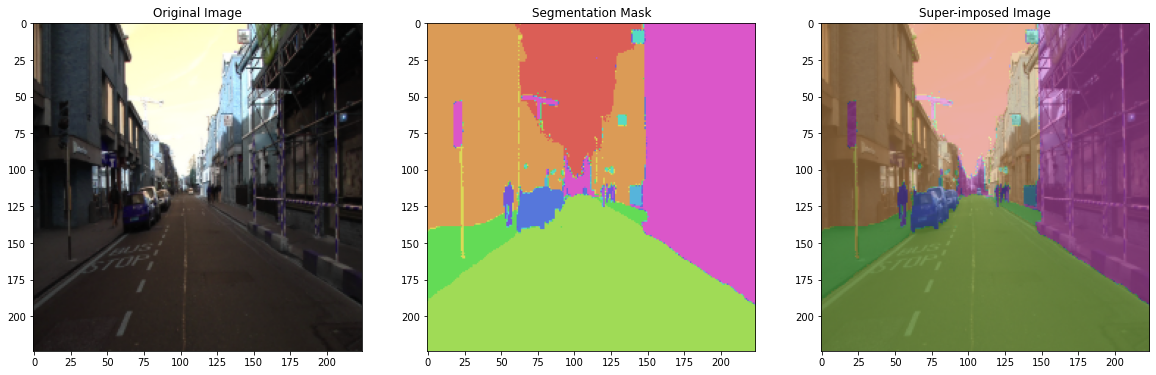

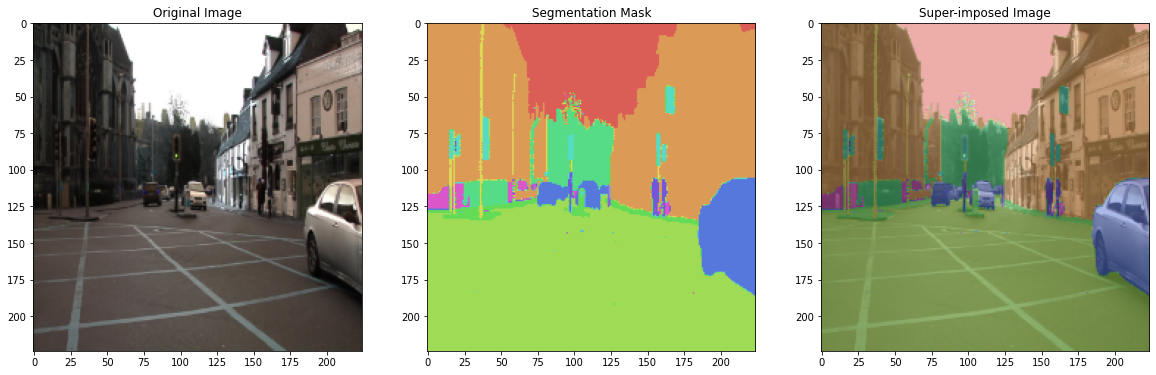

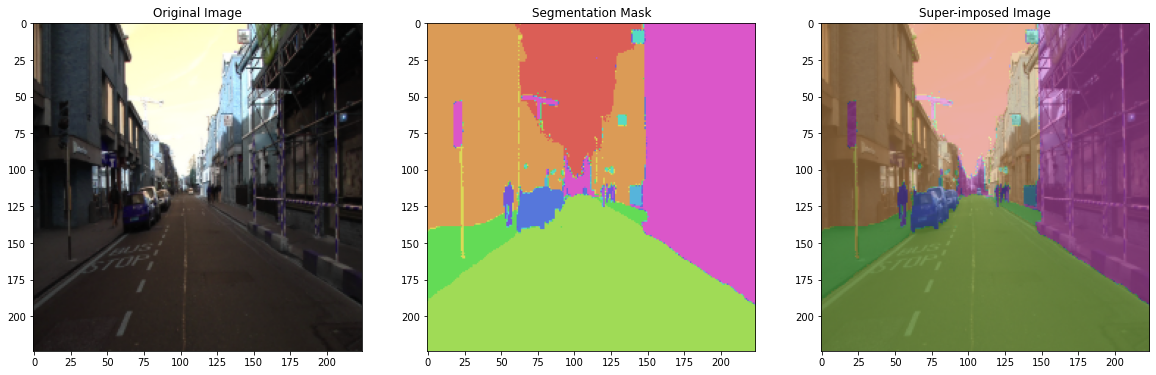

In [54]:
for i in range(3):
    a = randint(0, 50)
    plot_images(X_train[a], y_train[a])

# Part 1

In [55]:
HEIGHT, WIDTH = 224, 224
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT, WIDTH, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(12, (1, 1), padding="same", activation="softmax")(u4)
    model = Model(inputs, outputs)
    return model

In [56]:
# define callbacks for learning rate scheduling and best checkpoints saving
LR = 0.01
EPOCHS = 100

In [57]:
# checkpoint = ModelCheckpoint('seg_model.hdf5', monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint('seg_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [58]:
model_u = UNet()
model_u.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", iou_score, fscore])
model_u.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

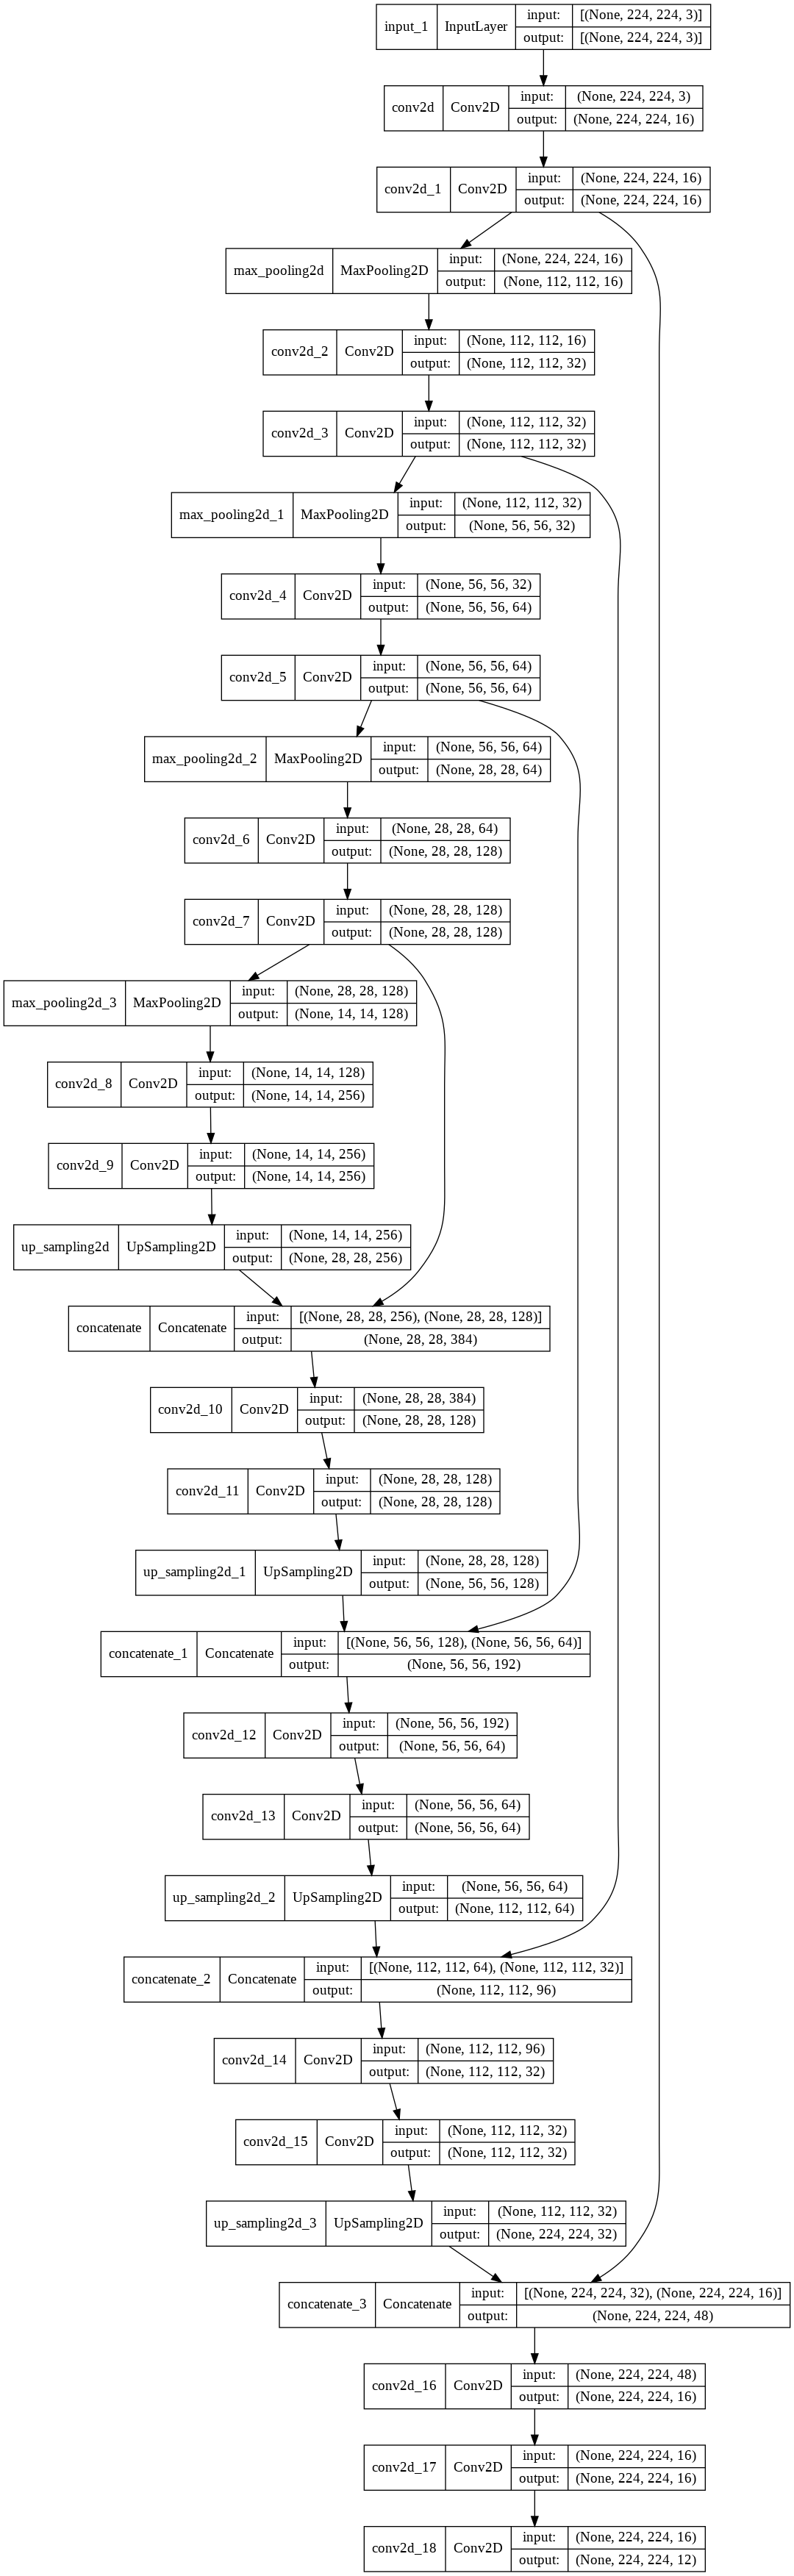

In [60]:
plot_model(model_u, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [61]:
history = model_u.fit(X_train, y_train, batch_size=10, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks = checkpoint)

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 2.2509 - accuracy: 0.1521 - iou_score: 0.0212 - f1-score: 0.0281
Epoch 00001: val_accuracy improved from -inf to 0.18543, saving model to seg_model.hdf5
26/26 [==============================] - 22s 363ms/step - loss: 2.2509 - accuracy: 0.1521 - iou_score: 0.0212 - f1-score: 0.0281 - val_loss: 1.9521 - val_accuracy: 0.1854 - val_iou_score: 0.0191 - val_f1-score: 0.0309
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 1.6712 - accuracy: 0.4228 - iou_score: 0.0648 - f1-score: 0.0837
Epoch 00002: val_accuracy improved from 0.18543 to 0.47801, saving model to seg_model.hdf5
26/26 [==============================] - 6s 250ms/step - loss: 1.6712 - accuracy: 0.4228 - iou_score: 0.0648 - f1-score: 0.0837 - val_loss: 1.3948 - val_accuracy: 0.4780 - val_iou_score: 0.1109 - val_f1-score: 0.1329
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 1.3179 - accuracy: 0.5717 - iou_score: 0.1137 - f

In [62]:
model_u.save("unet_100iterations.hdf5")

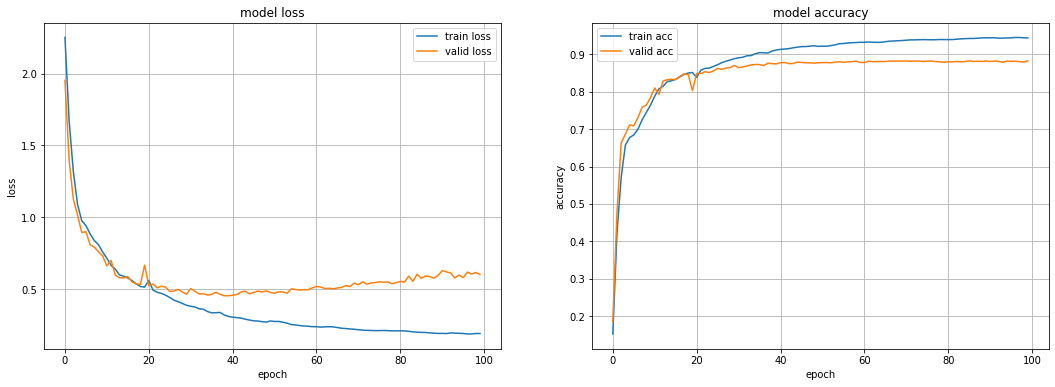

In [63]:
plot_history(history)

In [64]:
# Results
score = np.float16(model_u.evaluate(X_test, y_test))

print("Test loss: ", score[0])
print("Test accuracy: ", score[1]*100)
print('IoU: ', score[2])
print('F1 Score: ', score[3])

4/4 [==============================] - 4s 399ms/step - loss: 0.7581 - accuracy: 0.8658 - iou_score: 0.4632 - f1-score: 0.5397
Test loss:  0.7583
Test accuracy:  86.572265625
IoU:  0.4631
F1 Score:  0.5396


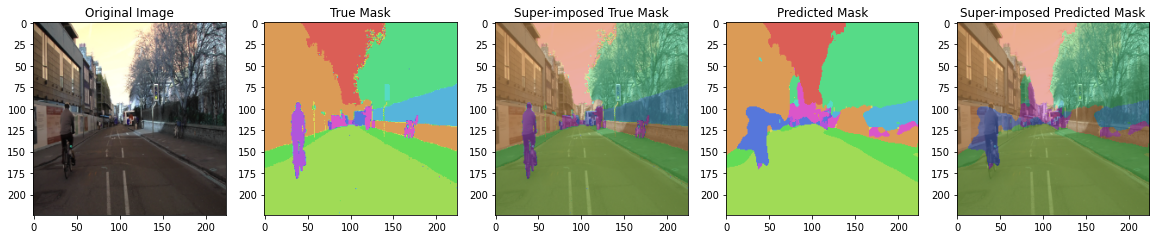

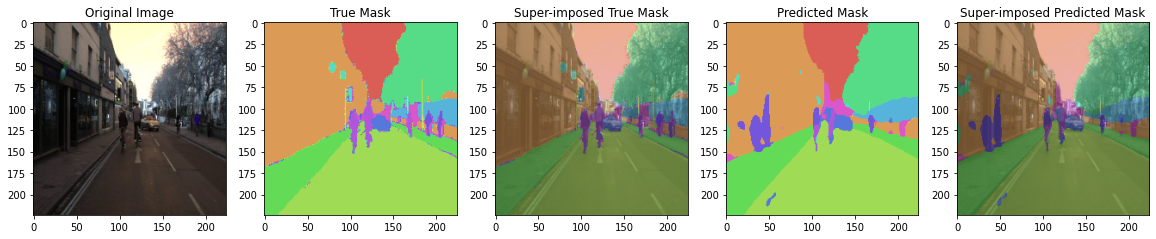

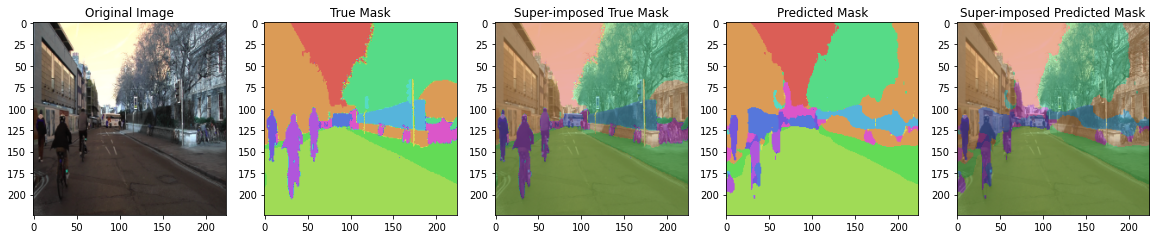

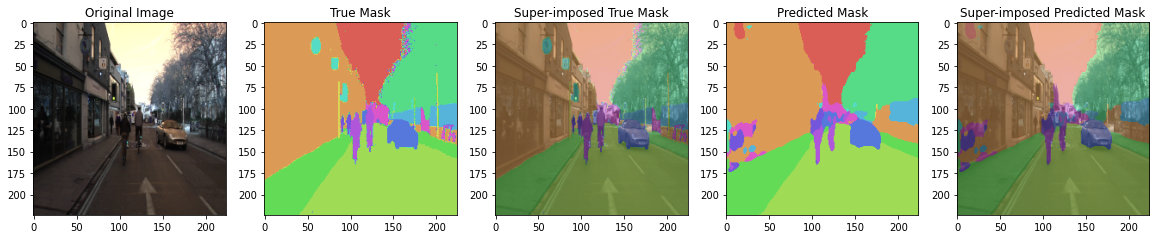

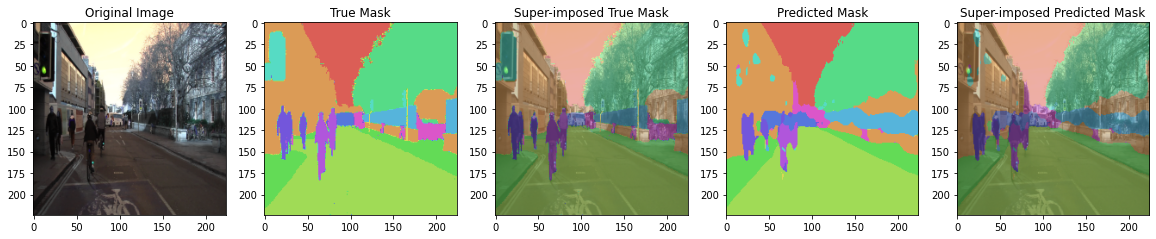

In [66]:
# we check out the results on some random images
predictions_test = model_u.predict(X_test)

# Plot predicted and true images
for a in range(0, 50, 10):
    i = randint(0,100)
    orig = X_test[i]
    annot = y_test[i]
    pred = predictions_test[i]
    plot_images_pred(orig, annot, pred)
    

Sensitivity
Consider the example of a medical test for diagnosing a condition. Sensitivity refers to the test's ability to correctly detect ill patients who do have the condition.[11] In the example of a medical test used to identify a condition, the sensitivity (sometimes also named the detection rate in a clinical setting) of the test is the proportion of people who test positive for the disease among those who have the disease. Mathematically, this can be expressed as:

{\displaystyle {\begin{aligned}{\text{sensitivity}}&={\frac {\text{number of true positives}}{{\text{number of true positives}}+{\text{number of false negatives}}}}\\[8pt]&={\frac {\text{number of true positives}}{\text{total number of sick individuals in population}}}\\[8pt]&={\text{probability of a positive test given that the patient has the disease}}\end{aligned}}}{\displaystyle {\begin{aligned}{\text{sensitivity}}&={\frac {\text{number of true positives}}{{\text{number of true positives}}+{\text{number of false negatives}}}}\\[8pt]&={\frac {\text{number of true positives}}{\text{total number of sick individuals in population}}}\\[8pt]&={\text{probability of a positive test given that the patient has the disease}}\end{aligned}}}
A negative result in a test with high sensitivity is useful for ruling out disease.[11] A high sensitivity test is reliable when its result is negative, since it rarely misdiagnoses those who have the disease. A test with 100% sensitivity will recognize all patients with the disease by testing positive. A negative test result would definitively rule out presence of the disease in a patient. However, a positive result in a test with high sensitivity is not necessarily useful for ruling in disease. Suppose a 'bogus' test kit is designed to always give a positive reading. When used on diseased patients, all patients test positive, giving the test 100% sensitivity. However, sensitivity does not take into account false positives. The bogus test also returns positive on all healthy patients, giving it a false positive rate of 100%, rendering it useless for detecting or "ruling in" the disease.

The calculation of sensitivity does not take into account indeterminate test results. If a test cannot be repeated, indeterminate samples either should be excluded from the analysis (the number of exclusions should be stated when quoting sensitivity) or can be treated as false negatives (which gives the worst-case value for sensitivity and may therefore underestimate it).

Specificity
Consider the example of a medical test for diagnosing a disease. Specificity relates to the test's ability to correctly reject healthy patients without a condition. Specificity of a test is the proportion of who truly do not have the condition who test negative for the condition. Mathematically, this can also be written as:

{\displaystyle {\begin{aligned}{\text{specificity}}&={\frac {\text{number of true negatives}}{{\text{number of true negatives}}+{\text{number of false positives}}}}\\[8pt]&={\frac {\text{number of true negatives}}{\text{total number of well individuals in population}}}\\[8pt]&={\text{probability of a negative test given that the patient is well}}\end{aligned}}}{\displaystyle {\begin{aligned}{\text{specificity}}&={\frac {\text{number of true negatives}}{{\text{number of true negatives}}+{\text{number of false positives}}}}\\[8pt]&={\frac {\text{number of true negatives}}{\text{total number of well individuals in population}}}\\[8pt]&={\text{probability of a negative test given that the patient is well}}\end{aligned}}}
A positive result in a test with high specificity is useful for ruling in disease. The test rarely gives positive results in healthy patients. A positive result signifies a high probability of the presence of disease.[12] A test with 100% specificity will recognize all patients without the disease by testing negative, so a positive test result would definitely rule in the presence of the disease. However, a negative result from a test with a high specificity is not necessarily useful for ruling out disease. For example, a test that always returns a negative test result will have a specificity of 100% because specificity does not consider false negatives. A test like that would return negative for patients with the disease, making it useless for ruling in disease.

A test with a higher specificity has a lower type I error rate.

The Intersection over Union (IoU) metric, also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and our prediction output. This metric is closely related to the Dice coefficient which is often used as a loss function during training.

Quite simply, the IoU metric measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks.

IoU=target∩predictiontarget∪prediction

Intuitively, a successful prediction is one which maximizes the overlap between the predicted and true objects. Two related but different metrics for this goal are the Dice and Jaccard coefficients (or indices):

D
i
c
e
(
A
,
B
)
=
2
∥
A
∩
B
∥
∥
A
∥
+
∥
B
∥
,
J
a
c
c
a
r
d
(
A
,
B
)
=
∥
A
∩
B
∥
∥
A
∪
B
∥
Here, 
A
 and 
B
 are two segmentation masks for a given class (but the formulas are general, that is, you could calculate this for anything, e.g. a circle and a square), 
∥
A
∥
 is the norm of 
A
 (for images, the area in pixels), and 
∩
, 
∪
 are the intersection and union operators.

Both the Dice and Jaccard indices are bounded between 0 (when there is no overlap) and 1 (when A and B match perfectly). The Jaccard index is also known as Intersection over Union (IoU) and because of its simple and intuitive expression is widely used in computer vision applications.

In terms of the confusion matrix, the metrics can be rephrased in terms of true/false positives/negatives:

D
i
c
e
=
2
T
P
2
T
P
+
F
P
+
F
N
,
J
a
c
c
a
r
d
=
I
o
U
=
T
P
T
P
+
F
P
+
F
N
Here is an illustration of the Dice and IoU metrics given two circles representing the ground truth and the predicted masks for an arbitrary object class:

IoU, Dice example

Why choose one over the other? See this StackOverflow question for a comparison between Dice and IoU. In general, the IoU is more intuitive and more commonly used.

In [110]:
def compute_scores(y_pred, y_test, n_classes=None):
    
    print("No. of classes: ", n_classes)
    class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
    # generate class no.s
    y_test_fl = y_pred_fl = np.zeros(y_pred.shape)
    for i in range(n_classes):
        y_test_fl[:, :, :, i] = np.where(y_test[:,:,:, i] == 0, 0, i+1)
        y_pred_fl[:, :, :, i] = np.where(y_pred[:,:,:, i] == 0, 0, i+1)
    
    prediction   = y_pred_fl.reshape(-1,)
    labels = y_test_fl.reshape(-1,)
    
    # Create classification report
    print("Classification Report")
    print(classification_report(prediction, labels, target_names=class_labels))
    print("\n")
    
    # Create confusion matrix
    print("Confusion Matrix")
    print('''[‘True Neg’,’False Pos’,
    ’False Neg’,’True Pos’]''')
    cmat  = confusion_matrix(labels, prediction)
    plt.figure(figsize = (16,16))
    sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
    plt.xlabel("Predictions")
    plt.ylabel("Ground Truths")
    plt.show()
    print("\n")
    
    FP = cmat.sum(axis=0) - np.diag(cmat)  
    FN = cmat.sum(axis=1) - np.diag(cmat)
    TP = np.diag(cmat)
    TN = cmat.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    #     Compute Dice Score
    y_pred_fl = (y_pred_fl > 0).astype(np.float16)
    print("Dice Score: ", np.float16(2. * (y_pred_fl*y_test_fl).sum() / (y_pred_fl+y_test_fl).sum()))
    
    # IoU Loss (Jacard Loss)
    intersection = np.logical_and(labels, prediction)
    union = np.logical_or(labels, prediction)
    iou_ = np.sum(intersection) / np.sum(union)
    print("IoU Score: ", iou_)
    print("\n")
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print('Sensitivity (TPR) : ', TPR)

    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print('Specificity (TNR) : ', TNR)

    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print('Precision (PPV) : ', PPV)

    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print('FPR : ', FPR)
    # False negative rate
    FNR = FN/(TP+FN)
    print('FNR : ', FNR)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print('Accuracy : ', ACC)
    
    # print('Micro Precision: {:.2f}'.format(precision_score(prediction, labels, average='micro')))
    # print('Micro Recall: {:.2f}'.format(recall_score(prediction, labels, average='micro')))
    # print('Micro F1-score: {:.2f}\n'.format(f1_score(prediction, labels, average='micro')))

    # print('Macro Precision: {:.2f}'.format(precision_score(prediction, labels, average='macro')))
    # print('Macro Recall: {:.2f}'.format(recall_score(prediction, labels, average='macro')))
    # print('Macro F1-score: {:.2f}\n'.format(f1_score(prediction, labels, average='macro')))

    # print('Weighted Precision: {:.2f}'.format(precision_score(prediction, labels, average='weighted')))
    # print('Weighted Recall: {:.2f}'.format(recall_score(prediction, labels, average='weighted')))
    # print('Weighted F1-score: {:.2f}'.format(f1_score(prediction, labels, average='weighted')))

No. of classes:  12
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9861
           1       1.00      1.00      1.00   5064361
           2       1.00      1.00      1.00   5067742
           3       1.00      1.00      1.00   5067776
           4       1.00      1.00      1.00   5067776
           5       1.00      1.00      1.00   5067776
           6       1.00      1.00      1.00   5067776
           7       1.00      1.00      1.00   5067776
           8       1.00      1.00      1.00   5067684
           9       1.00      1.00      1.00   5067694
          10       1.00      1.00      1.00   5067548
          11       1.00      1.00      1.00   5063513
          12       1.00      1.00      1.00   5066029

    accuracy                           1.00  60813312
   macro avg       1.00      1.00      1.00  60813312
weighted avg       1.00      1.00      1.00  60813312



Confusion Matrix
[‘True Neg’,’False

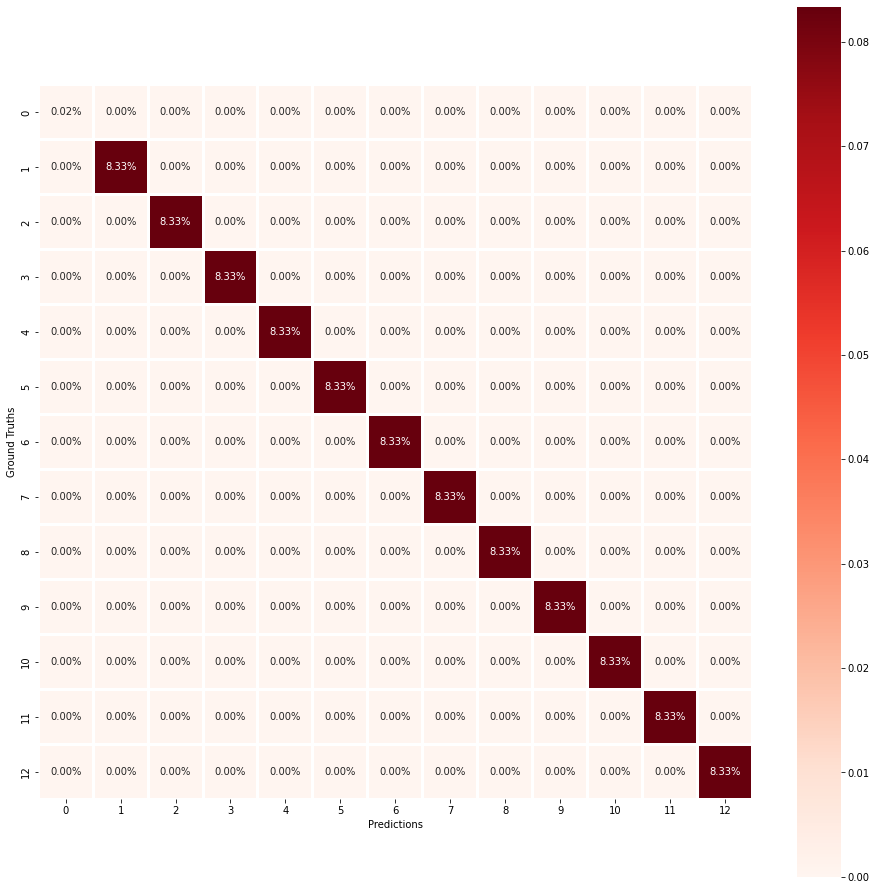



Dice Score:  1.733
IoU Score:  1.0


Sensitivity (TPR) :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Specificity (TNR) :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Precision (PPV) :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
FPR :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
FNR :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [68]:
classes = len(y_test[0,0,0])
compute_scores(predictions_test, y_test, classes)

In [69]:
# one hot encoding of predictions
# y_pred = predictions_resnet
y_pred = predictions_test
y_true = y_test
num_classes = y_pred.shape[-1]
y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)

axes = (1,2) # W,H axes of each image
intersection = np.sum(np.logical_and(y_pred, y_true), axis=axes)
# intersection = np.sum(np.abs(y_pred * y_true), axis=axes)
union = np.sum(np.logical_or(y_pred, y_true), axis=axes)
mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
union = mask_sum  - intersection

smooth = .01
iou = (intersection + smooth) / (union + smooth)
dice = 2 * (intersection + smooth) / (mask_sum + smooth)

iou_avg = np.mean(iou)
dice_avg = np.mean(dice)
print("Mean IoU ", iou_avg)
print("Mean Dice :", dice_avg)

Mean IoU  0.481501634815335
Mean Dice : 0.5639442714720841


# Part 2

In [70]:
from keras.utils import generic_utils

In [92]:
keras.backend.set_image_data_format('channels_last')

# BACKBONE = 'resnet101'
BACKBONE = 'resnet50'

In [93]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    return 1 - numerator / denominator

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [94]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [95]:
BACKBONE

'resnet50'

In [96]:
# define model
# model = sm.Unet('vgg16', input_shape=(HEIGHT, WIDTH, 3), classes=12, activation='sigmoid', encoder_weights=None,  decoder_use_batchnorm=False)
model_r = sm.Unet(BACKBONE, input_shape=(HEIGHT, WIDTH, 3), classes=12, activation='sigmoid', encoder_weights=None,  decoder_use_batchnorm=False)


model_r.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
                   loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",iou_score, dice_coef])

# callbacks = [ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1)]
callbacks = [ReduceLROnPlateau(min_lr=0.000001, verbose=1)]

In [97]:
model_r.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_88 (ZeroPadding  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.834084 to fit



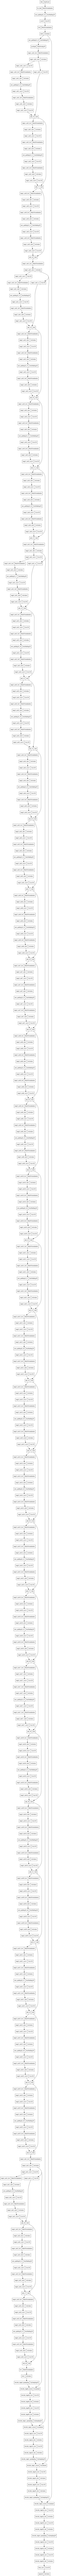

In [98]:
plot_model(model)

In [99]:
results = model_r.fit(X_train, y_train, batch_size=10,
                         verbose=1, epochs=100, callbacks = callbacks,
                         validation_data=(X_val, y_val))

Epoch 1/100
26/26 [==============================] - 23s 600ms/step - loss: 2.4772 - accuracy: 0.4180 - iou_score: 0.0917 - dice_coef: 0.2055 - val_loss: 305888.7500 - val_accuracy: 0.1658 - val_iou_score: 0.0634 - val_dice_coef: 0.2128 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 14s 548ms/step - loss: 1.2149 - accuracy: 0.6330 - iou_score: 0.1378 - dice_coef: 0.2934 - val_loss: 623.3204 - val_accuracy: 0.3591 - val_iou_score: 0.0865 - val_dice_coef: 0.3137 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 14s 551ms/step - loss: 1.0227 - accuracy: 0.6623 - iou_score: 0.1725 - dice_coef: 0.3291 - val_loss: 15.1813 - val_accuracy: 0.4918 - val_iou_score: 0.1202 - val_dice_coef: 0.3262 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 14s 550ms/step - loss: 0.9426 - accuracy: 0.6876 - iou_score: 0.1867 - dice_coef: 0.3418 - val_loss: 2.2102 - val_accuracy: 0.5365 - val_iou_score: 0.1303 - val_dice_coef: 0.3182 - lr: 0.0010
Epoch 5/100


In [100]:
model.save("unet_resnet50.hdf5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


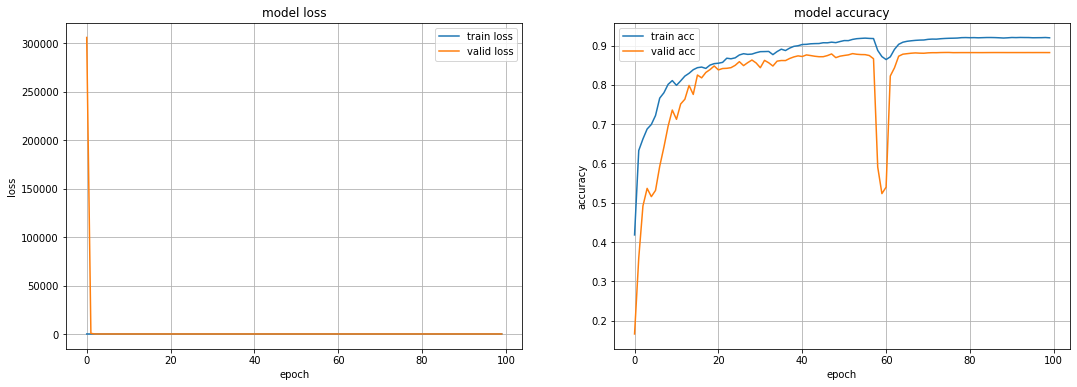

In [101]:
plot_history(results)

In [104]:
# Results
score = np.float16(model_r.evaluate(X_test, y_test))

print("Test loss: ", score[0])
print("Test accuracy: ", score[1]*100)
print('IoU: ', score[2])
print('Dice: ', score[3])

4/4 [==============================] - 1s 305ms/step - loss: 0.4729 - accuracy: 0.8694 - iou_score: 0.2212 - dice_coef: 0.3601
Test loss:  0.473
Test accuracy:  86.962890625
IoU:  0.2212
Dice:  0.36


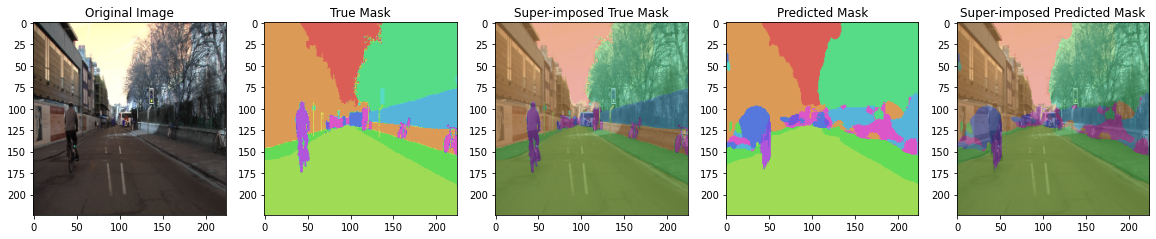

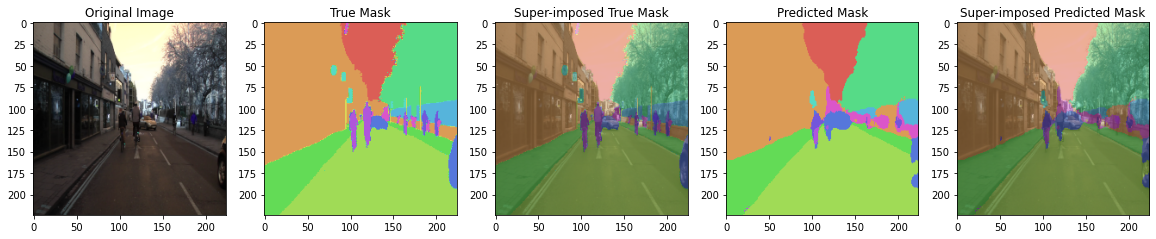

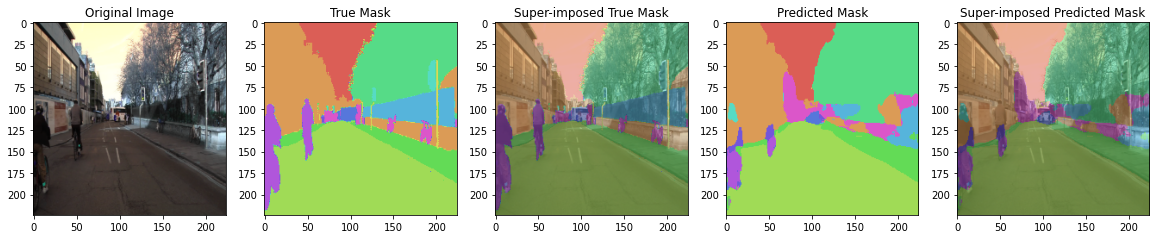

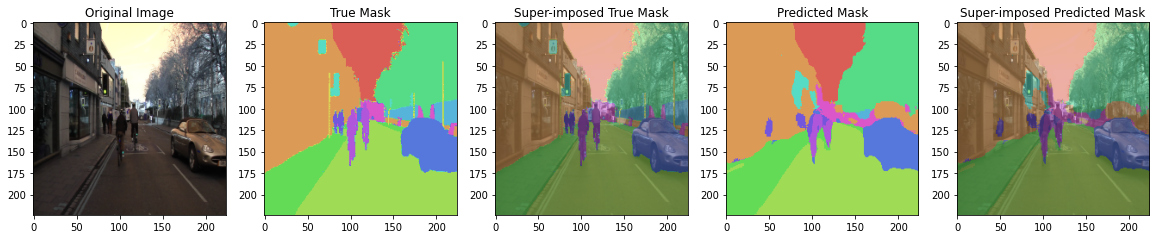

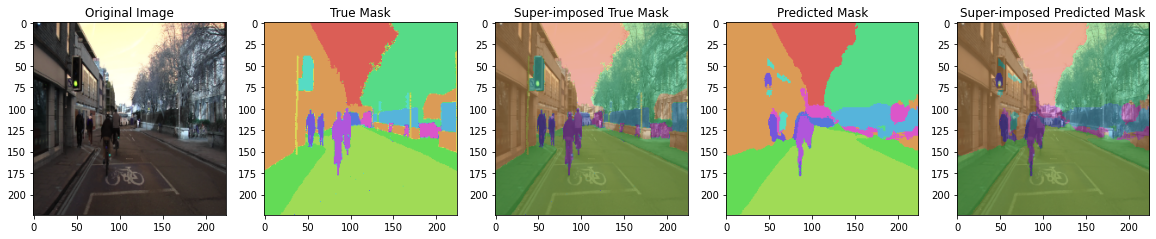

In [106]:
# we check out the results on some random images
predictions_resnet = model_r.predict(X_test)

# Plot predicted and true images
for a in range(0, 50, 10):
    i = randint(0,100)
    orig = X_test[i]
    annot = y_test[i]
    pred = predictions_resnet[i]
    plot_images_pred(orig, annot, pred)
    


No. of classes:  12
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5067776
           1       1.00      1.00      1.00   5067776
           2       1.00      1.00      1.00   5067776
           3       1.00      1.00      1.00   5067776
           4       1.00      1.00      1.00   5067776
           5       1.00      1.00      1.00   5067776
           6       1.00      1.00      1.00   5067776
           7       1.00      1.00      1.00   5067776
           8       1.00      1.00      1.00   5067776
           9       1.00      1.00      1.00   5067776
          10       1.00      1.00      1.00   5067776
          11       1.00      1.00      1.00   5067776

    accuracy                           1.00  60813312
   macro avg       1.00      1.00      1.00  60813312
weighted avg       1.00      1.00      1.00  60813312



Confusion Matrix
[‘True Neg’,’False Pos’,
    ’False Neg’,’True Pos’]


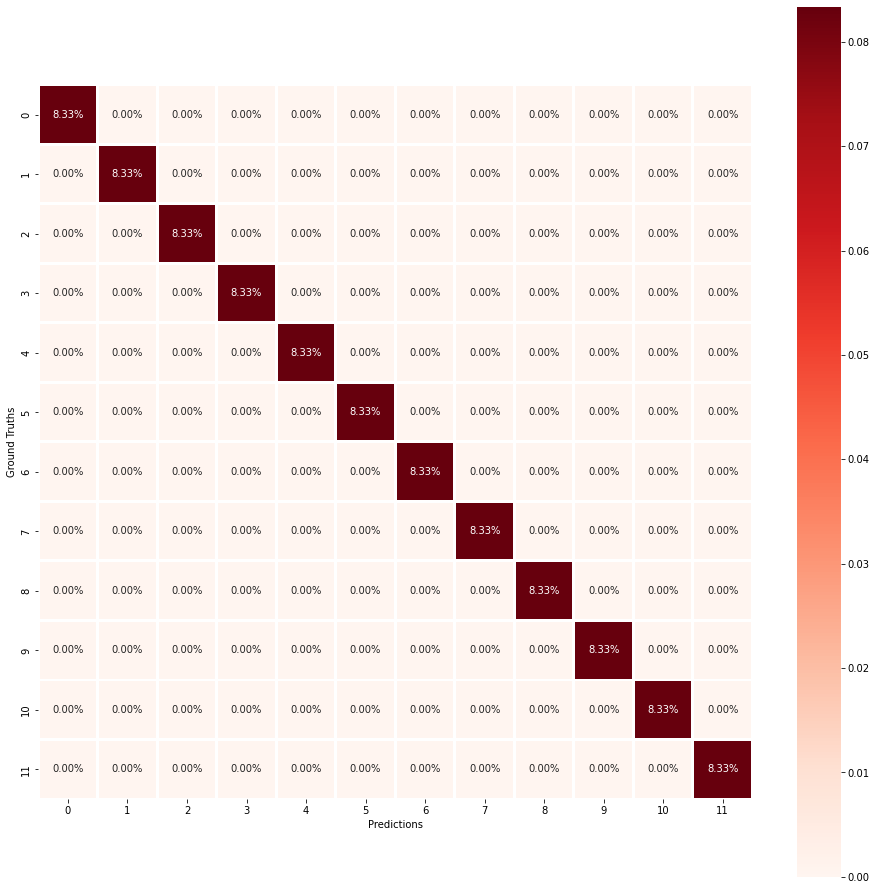



Dice Score:  1.733
IoU Score:  1.0


Sensitivity (TPR) :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Specificity (TNR) :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Precision (PPV) :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
FPR :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
FNR :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [111]:
classes = len(y_test[0,0,0])
compute_scores(predictions_resnet, y_test, 12)